https://inspiringpeople.github.io/data%20analysis/midi-music-data-extraction-using-music21/

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [19]:
def concat_path(path, child):
    return path + "/" + child

In [6]:
'''# Defining some constants and creating a new folder for MIDIs.
midi_path = "MIDIs"
sonic_folder = "sonic"

!rm -r $midi_path
!mkdir $midi_path

# Some helper methods.    
def concat_path(path, child):
    return path + "/" + child

def download_midi(midi_url, path):
    !wget $midi_url --directory-prefix $path > download_midi.log

# Downloading an example file.
sonic_path = concat_path(midi_path, sonic_folder)
download_midi(
    "https://files.khinsider.com/midifiles/genesis/sonic-the-hedgehog/green-hill-zone.mid",
    sonic_path)
    
print(os.listdir(sonic_path))'''

'# Defining some constants and creating a new folder for MIDIs.\nmidi_path = "MIDIs"\nsonic_folder = "sonic"\n\n!rm -r $midi_path\n!mkdir $midi_path\n\n# Some helper methods.    \ndef concat_path(path, child):\n    return path + "/" + child\n\ndef download_midi(midi_url, path):\n    !wget $midi_url --directory-prefix $path > download_midi.log\n\n# Downloading an example file.\nsonic_path = concat_path(midi_path, sonic_folder)\ndownload_midi(\n    "https://files.khinsider.com/midifiles/genesis/sonic-the-hedgehog/green-hill-zone.mid",\n    sonic_path)\n    \nprint(os.listdir(sonic_path))'

In [7]:
# !pip install music21

In [8]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

sonic_path = 'MIDIs/sonic'


def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(os.path.join(sonic_path, "green-hill-zone.mid"), True)
base_midi


<music21.stream.Score 0x22572903580>

In [9]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
Taken from:
www.alphalink.com.au/~kosy
WinJammer Demo
WinJammer Demo
WinJammer Demo
WinJammer Demo
WinJammer Demo
WinJammer Demo


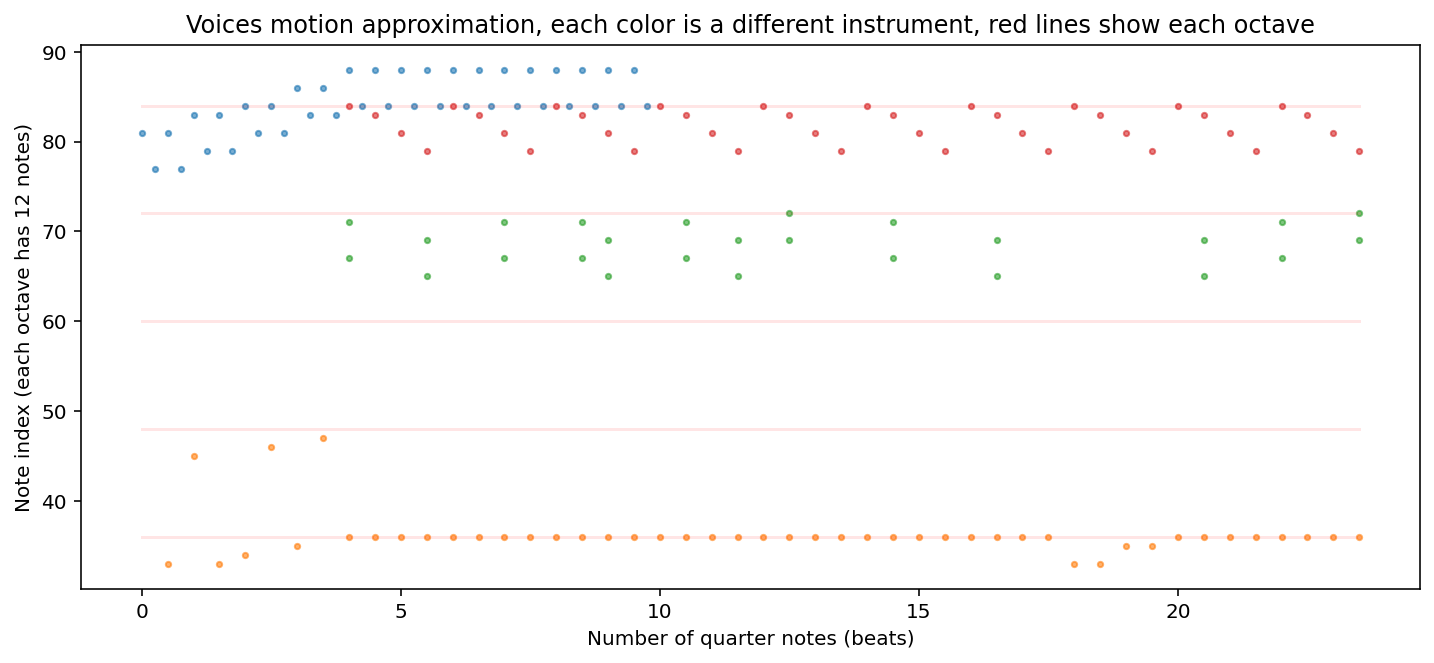

In [10]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x22572903580>>

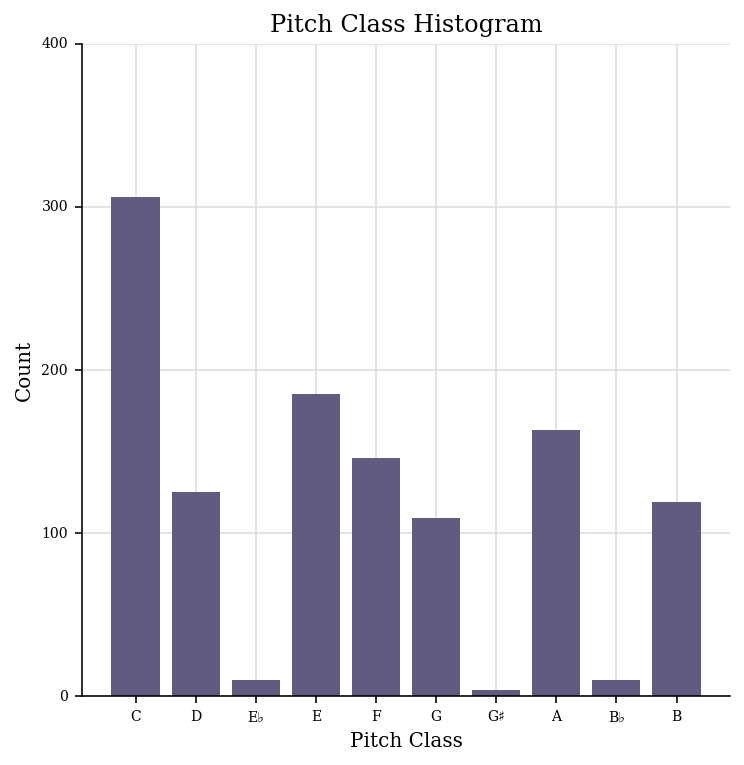

In [11]:
base_midi.plot('histogram', 'pitchClass', 'count')

<music21.graph.plot.ScatterPitchClassOffset for <music21.stream.Score 0x22572903580>>

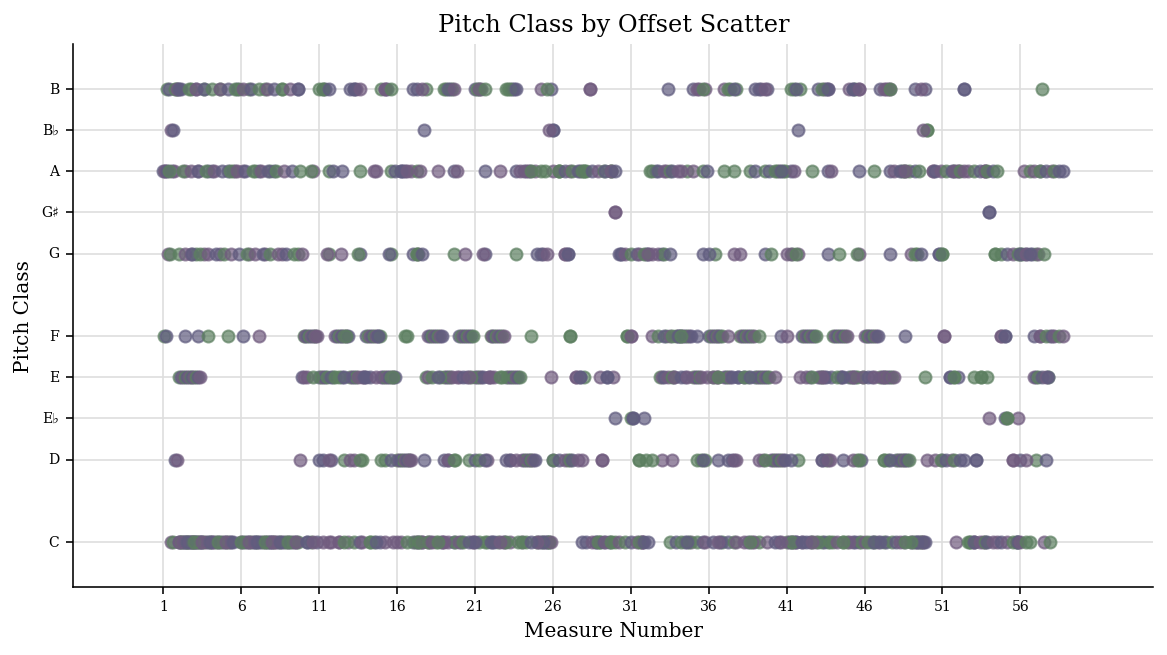

In [12]:
base_midi.plot('scatter', 'offset', 'pitchClass')

In [13]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: a minor
Music key confidence: 0.8770275812674332
Other music key alternatives:
C major
F major
G major
d minor


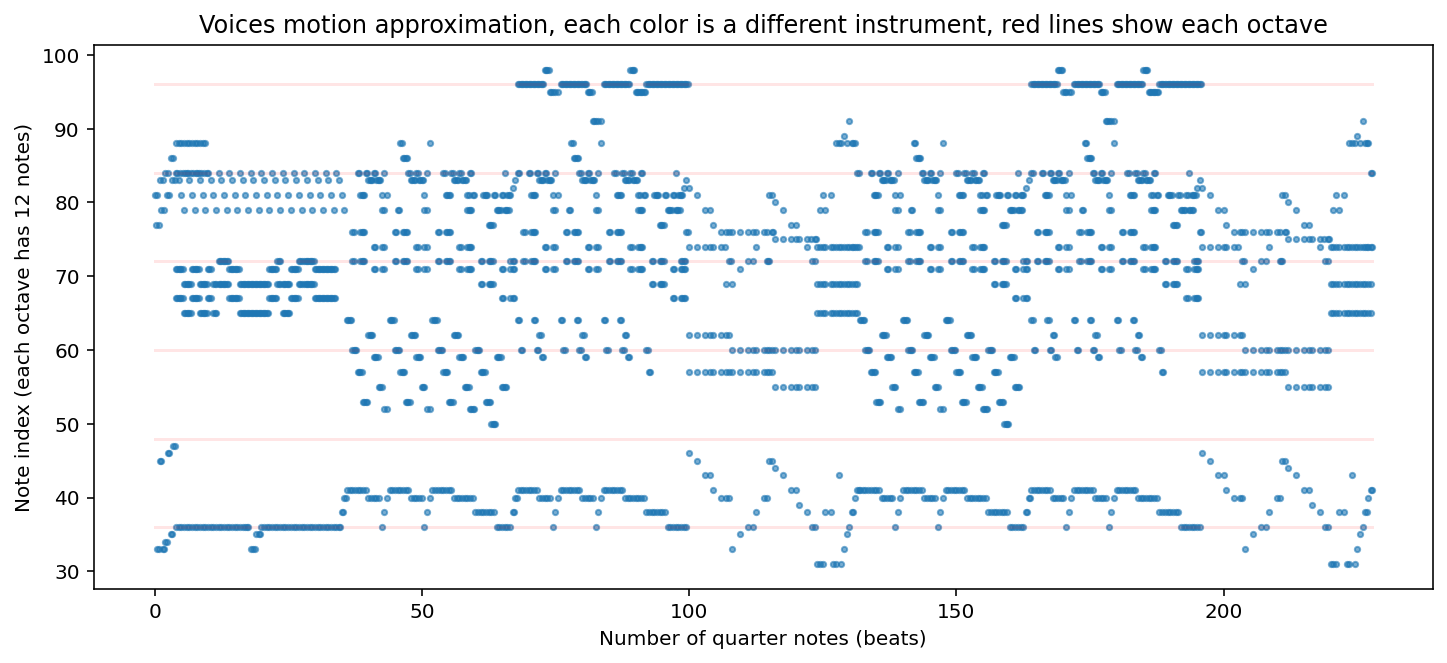

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Taken from:: Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=175.0>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord A5>
    {0.25} <music21.chord.Chord F5>
    {0.5} <music21.chord.Chord A1 A5>
    {0.75} <music21.chord.Chord A1 F5>
    {1.0} <music21.chord.Chord A2 B5>
    {1.25} <music21.chord.Chord A2 G5>
    {1.5} <music21.chord.Chord A1 B5>
    {1.75} <music21.chord.Chord A1 G5>
    {2.0} <music21.chord.Chord B-1 C6>
    {2.25} <music21.chord.Chord B-1 A5>
    {2.5} <music21.chord.Chord B-2 C6>
    {2.75} <music21.chord.Chord B-2 A5>
    {3.0} <music21.chord.Chord B1 D6>
    {3.25} <music21.chord.Chord B1 B5>
    {3.5} <music21.chord.Chord B2 D6>
    {3.75} <music21.chord.Chord B2 B5>


In [14]:
from music21 import stream

temp_midi_chords = open_midi(
    os.path.join(sonic_path, "green-hill-zone.mid"),
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")

In [15]:
from music21 import roman

def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

harmonic_reduction(base_midi)[0:10]

['ii42', 'III43', 'VI64', 'i42', 'VI', 'i65', 'i65', 'i42', 'III7', 'vi7']

In [16]:
from music21 import corpus

bachChorale = corpus.parse('bach/bwv846')
harmonic_reduction(bachChorale)[0:11]

['I', 'ii42', 'vii53', 'I', 'vi6', 'ii42', 'V6', 'i42', 'vi7', 'II7', 'V']

In [21]:
'''import requests
from bs4 import BeautifulSoup

def get_file_name(link):
    filename = link.split('/')[::-1][0]
    return filename

def download_file(link, filename):
    mid_file_request = requests.get(link, stream=True)
    if (mid_file_request.status_code != 200):
        raise Exception("Failed to download {0}".format(link))
        
    with open(filename, 'wb+') as saveMidFile:
        saveMidFile.write(mid_file_request.content)

def download_midi_files(url, output_path):
    site_request = requests.get(url)
    if (site_request.status_code != 200):
        raise Exception("Failed to access {0}".format(url))
    
    soup = BeautifulSoup(site_request.content, 'html.parser')
    link_urls = soup.find_all('a')

    for link in link_urls:
        href = link['href']
        if (href.endswith(".mid")):
            file_name = get_file_name(href)
            download_path = concat_path(output_path, file_name)
            midi_request = download_file(href, download_path)

def start_midis_download(folder, url):
    !mkdir $folder # It is fine if this command fails when the directory already exists.
    download_midi_files(url, folder)

target_games = dict()
target_games["sonic1"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog"
target_games["sonic2"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog-2"
target_games["sonic3"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog-3"
target_games["sonicAndKnuckles"] = "https://www.khinsider.com/midi/genesis/sonic-and-knuckles"

for key, value in target_games.items():
    file_path = concat_path(sonic_path, key)
    os.makedirs(file_path)
    start_midis_download(file_path, value)'''

���� ������ �ùٸ��� �ʽ��ϴ�.
���� ������ �ùٸ��� �ʽ��ϴ�.
���� ������ �ùٸ��� �ʽ��ϴ�.
���� ������ �ùٸ��� �ʽ��ϴ�.


In [22]:
# from multiprocessing.dummy import Pool as ThreadPool # Use this when IO is the problem
from multiprocessing import Pool # Use this when CPU-intensive functions are the problem.

# Go get a coffee, this cell takes hours to run...
def process_single_file(midi_param):
    try:
        game_name = midi_param[0]
        midi_path = midi_param[1]
        midi_name = get_file_name(midi_path)
        midi = open_midi(midi_path, True)
        return (
            midi.analyze('key'),
            game_name,
            harmonic_reduction(midi),
            midi_name)
    except Exception as e:
        print("Error on {0}".format(midi_name))
        print(e)
        return None

def create_midi_dataframe(target_games):
    key_signature_column = []
    game_name_column = []
    harmonic_reduction_column = []
    midi_name_column = []
    pool = Pool(8)
    midi_params = []
    for key, value in target_games.items():
        folder_path = concat_path(sonic_path, key)
        for midi_name in os.listdir(folder_path):
            midi_params.append((key, concat_path(folder_path, midi_name)))

    results = pool.map(process_single_file, midi_params)
    for result in results:
        if (result is None):
            continue
            
        key_signature_column.append(result[0])
        game_name_column.append(result[1])
        harmonic_reduction_column.append(result[2])
        midi_name_column.append(result[3])
    
    d = {'midi_name': midi_name_column,
         'game_name': game_name_column,
         'key_signature' : key_signature_column,
         'harmonic_reduction': harmonic_reduction_column}
    return pd.DataFrame(data=d)

sonic_df = create_midi_dataframe(target_games)